In [1]:
import os
import json
import pandas as pd
import csv
import itertools
import numpy as np
import json
import pickle

#import matplotlib as mpl
#mpl.rcParams['agg.path.chunksize'] = 10000
from matplotlib import pyplot as plt
plt.rcParams['agg.path.chunksize'] = 1000000
from matplotlib.ticker import FuncFormatter, LogFormatterExponent, ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sb

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
sb.set_style("darkgrid")
sb.set_context("paper",  font_scale = 1,
                   rc={
                       "grid.linewidth": 3.75,
                       'axes.labelsize': 28,
                       "axes.titlesize": 32,
                       "legend.fontsize": 28.0,
                       'lines.linewidth': 5,
                       'xtick.labelsize': 24.0,
                       'ytick.labelsize': 24.0,
                   })
current_palette = list(sb.color_palette())
colors = {
        'RL': current_palette[0],
        'RR': current_palette[5],
        'SOP':current_palette[4],
        'RAND':current_palette[7],
        'optimal':current_palette[1],
        '0':current_palette[-2],
        '1':current_palette[-1]
    }

In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [4]:
def merge_and_mean(data):
    ds = np.array(sorted(data, key=len))
    lengths = [len(d) for d in ds]
    means = []
    stds = []
    for i in range(len(lengths)):
        if i == 0:
            shorts = [d[:lengths[i]] for d in ds]
            means.append(np.mean(shorts, axis=0))
            stds.append(np.std(shorts, axis=0))
        else:
            shorts = [d[lengths[i-1]:lengths[i]] for d in ds]
            means.append(np.mean(shorts, axis=0))
            stds.append(np.std(shorts, axis=0))
        ds = ds[1:]
    means = [item for sublist in means for item in sublist]
    stds = [item for sublist in stds for item in sublist]
    return np.array(means), np.array(stds)

In [5]:
def plot_means(suffixes=[""], problem="", exp=[1, 2], name=[""],
               quantile=False, test=False, evaluate=False, labels=[0, 1, 2, 3, 4], ylim=[0, 11], smoothing=10):
    fig = plt.figure(figsize=(12, 5), dpi=50)
    lab=0
    colors=current_palette
    k=0
    for n in name:
        dfs = []
        c = colors[k]
        k+=1
        for s in suffixes:
            ax = plt.gca()
            for exploration in exp:
                if n == "spdl_trpo":
                    exp_dir = f'results/spdl_trpo/point_mass/self_paced/trpo_ALPHA_OFFSET=70_MAX_KL=0.05_OFFSET=5_ZETA=1.6/seed-{s}'
                    try:
                        file = open(f'{exp_dir}/performance_specific.pkl','rb')
                        performance = pickle.load(file)
                        file.close()
                        means = [p[0] for p in performance]
                        df = pd.DataFrame({'rewards': means})
                        dfs.append(df)  
                    except:
                        pass
                else:
                    exp_dir = os.path.join(
                        os.path.sep, 'results', '%s%s' % (n, s))
                    try:
                        if test:
                            file = 'test_reward.txt'
                        elif evaluate:
                            file = 'eval_reward.txt'
                        else:
                            file = 'train_reward.txt'
                        df = pd.read_csv(os.path.join(exp_dir, file), sep='\t',
                                     index_col=None)
                        dfs.append(df)
                    except Exception as e:
                        print(e)

        means = [df[df.columns[0]].values for df in dfs]
        means_mean, std_means = merge_and_mean(means)
        if n == "spdl_trpo":
            steps_mean = np.arange(len(means_mean))*5*2048
        else:
            steps = [df[df.columns[2]].values for df in dfs]
            steps_mean, _ = merge_and_mean(steps)
        u = means_mean + std_means
        l = means_mean - std_means
        if labels[lab] == "Random":
            steps_mean = np.arange(1000000)
            means_mean = np.ones(1000000)*means_mean[-1]
        steps_mean[0] = 0
        plt.plot(steps_mean, smooth(means_mean, smoothing), label=labels[lab], color=c)
        if not labels[lab] == "Random":
            plt.fill_between(steps_mean, smooth(u, smoothing), smooth(l, smoothing), step='post', color=c, alpha=0.25)
        plt.xlabel('#steps')
        lab+=1
        
    ax.set_ylabel('Normalized average reward')
    if test:
        ax.set_title(f'Performance Evaluation on Test Set')
    elif evaluate:
        ax.set_title(f'Performance Evaluation on Training Set')
    else:
        ax.set_title(f'Training Progress ({problem})')
    plt.ylim(ylim)
    plt.xlim([100, 1000000])
    plt.xlabel('#steps')
    plt.grid(True, which="both")
    ax.set_xscale('log')
    ax.legend(loc='upper left')
    p = problem.split()
    p_string = ""
    for s in p:
        p_string += s + "_"
    if test:
        plt.savefig(f'{p_string}test.png', bbox_inches='tight')
    elif evaluate:
        plt.savefig(f'{p_string}train.png', bbox_inches='tight')
    plt.show()
    return means_mean, steps_mean

In [11]:
def plot_progress(problem, names, suffixes, labels, ylim=[-10, 0], smoothing=10):
    means, steps = plot_means(suffixes=suffixes, problem=problem, name=names, labels=labels, ylim=ylim, smoothing=smoothing, evaluate=True)
    plot_means(suffixes=suffixes, problem=problem, name=names, labels=labels, ylim=ylim, smoothing=smoothing, test=True)
    return means, steps

In [331]:
problem="cpm_trpo"
files="cpm_trpo"
seeds=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
labels=["RR", "SPACE", "cSPACE"]

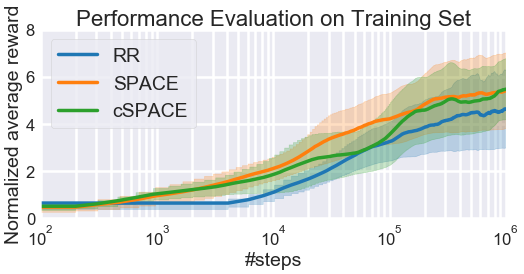

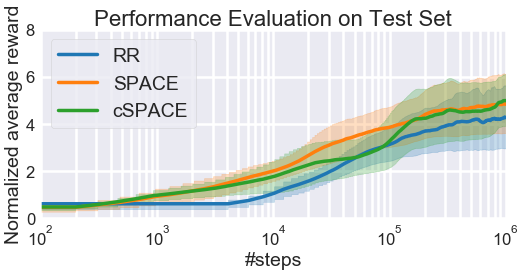

(array([0.67046287, 0.69472611, 0.8823232 , ..., 7.88857045, 7.90536609,
        7.88382493]),
 array([0.00000e+00, 2.00000e+02, 3.10000e+02, ..., 1.72063e+07,
        1.72163e+07, 1.72263e+07]))

In [332]:
plot_progress(suffixes=seeds, problem=f"{problem}", names=[f"{files}100_rr",
                                                           f"{files}100_spl",
                                                           f"{files}100_cl"],
                 labels=labels, ylim=[0, 8], smoothing=10)

In [ ]:
problem="antgoal"
out = plot_progress(suffixes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], problem=f"{problem}", names=[f"antgoal_oj_spl", 
                                                                                          f"antgoal_ppo_cl", 
                                                                                          f"antgoal_ppo_nonnorm_cl"],
                 labels=["SPACE", "Greedy (normalized)", "Greedy (not normalized)"], ylim=[0, 20], smoothing=10)

In [ ]:
import pandas as pd
fig = plt.figure(figsize=(12, 5), dpi=50)
df_spl = []
df_rr = []
df_vds = []

for s in np.arange(10):
    df_rr.append(pd.read_csv(f'results/vds_rr_s{s}/progress.monitor.csv', skiprows=[0]))
    df_vds.append(pd.read_csv(f'results/vds_s{s}/progress.monitor.csv', skiprows=[0]))
x_rr = np.mean([df["l"] for df in df_rr], axis=0)
original_rr = x_rr
zero = x_rr[0]
x_rr = [x_rr[i]+sum(x_rr[:i-1]) for i in range(1, len(x_rr))]
x_rr = [zero] + x_rr
y_rr = np.mean([df["r"] for df in df_rr], axis=0)
length = min(map(lambda x: len(x["r"]), df_rr))
std_rr = np.std([np.array(df["r"])[:length] for df in df_rr], axis=0)
x_vds = np.mean([df["l"] for df in df_vds], axis=0)
original_vds = x_vds
zero = x_vds[0]
x_vds = [x_vds[i]+sum(x_vds[:i-1]) for i in range(1, len(x_vds))]
x_vds = [zero] + x_vds
y_vds = np.mean([df["r"] for df in df_vds], axis=0)
length = min(map(lambda x: len(x["r"]), df_vds))
std_vds = np.std([np.array(df["r"])[:length] for df in df_vds], axis=0)

plt.plot(x_rr, smooth(y_rr, 10), label="RR", color="b")
plt.fill_between(x_rr, smooth(y_rr-std_rr, 10), smooth(y_rr+std_rr, 10), step='post', color="b", alpha=0.25)
plt.plot(x_vds, smooth(y_vds, 10), label="VDS", color="g")
plt.fill_between(x_vds[:length], smooth(y_vds[:length]-std_vds, 10), smooth(y_vds[:length]+std_vds, 10), step='post', color="g", alpha=0.25)
plt.legend()
plt.grid(True, which="both")
plt.xscale('log')
plt.xlabel("#steps")
plt.ylabel("Total undiscounted reward")
plt.ylim((0, 150))
plt.xlim((100, 1e5))
plt.savefig(f'vds.png', bbox_inches='tight')

#